In [107]:
import os
import matplotlib.pyplot as plt
import gym
from gym_minigrid.wrappers import *
from gym_minigrid.envs import EmptyEnv
from gym_minigrid.minigrid import Grid
from gym.wrappers import *
import rl_representation as rl
from rl_representation.src.envs.simulation import train_task_model
import torch
from torch import nn
import torch.nn.functional as F
import cv2
import numpy as np
import copy
import wandb
from tqdm import tqdm

# os.environ['WANDB_MODE'] = 'offline'
wandb.init()

%matplotlib inline

env_task_episode,▁▁▁▁▁▁▁▁
env_task_episode,0


wandb: wandb version 0.12.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [113]:
# Source: https://github.com/hwang-ua/fta_pytorch_implementation/blob/main/core/lta.py
class LTA(nn.Module):
    def __init__(self, input_dim, tiles=20, bound_low=-2, bound_high=2, eta=0.2):
        super(LTA, self).__init__()
        # 1 tiling, binning
        self.n_tilings = 1
        self.n_tiles = tiles
        self.bound_low, self.bound_high = bound_low, bound_high
        self.delta = (self.bound_high - self.bound_low) / self.n_tiles
        c_mat = torch.as_tensor(np.array([self.delta * i for i in range(self.n_tiles)]) + self.bound_low, dtype=torch.float32)
        self.register_buffer('c_mat', c_mat)
        self.eta = eta
        self.d = input_dim

    def forward(self, reps):
        temp = reps
        temp = temp.reshape([-1, self.d, 1])
        onehots = 1.0 - self.i_plus_eta(self.sum_relu(self.c_mat, temp))
        out = torch.reshape(torch.reshape(onehots, [-1]), [-1, int(self.d * self.n_tiles * self.n_tilings)])
        return out

    def sum_relu(self, c, x):
        out = F.relu(c - x) + F.relu(x - self.delta - c)
        return out

    def i_plus_eta(self, x):
        if self.eta == 0:
            return torch.sign(x)
        out = (x <= self.eta).type(torch.float32) * x + (x > self.eta).type(torch.float32)
        return out

In [114]:
# # Source: https://github.com/hwang-ua/fta_pytorch_implementation/blob/main/core/lta.py
# class FTA(nn.Module):
#     def __init__(self, input_dim, tiles=20, bound_low=-2, bound_high=2, eta=0.2):
#         super(FTA, self).__init__()
#         # 1 tiling, binning
#         self.n_tilings = 1
#         self.n_tiles = tiles
#         self.bound_low, self.bound_high = bound_low, bound_high
#         self.delta = (self.bound_high - self.bound_low) / self.n_tiles
#         c_mat = torch.as_tensor(np.array([self.delta * i for i in range(self.n_tiles)]) + self.bound_low, dtype=torch.float32)
#         self.register_buffer('c_mat', c_mat)
#         # self.c_mat = dict(self.named_buffers()).get('c_mat')
#         self.eta = eta
#         self.d = input_dim

#     def forward(self, x):
#         if len(x.shape) > 1:
#             c_mat = self.c_mat.unsqueeze(0)
#         else:
#             c_mat = self.c_mat

#         return 1 - self.fuzzy_indicator(F.relu(c_mat - x) \
#             + F.relu(x - self.delta - c_mat))

#     def fuzzy_indicator(self, x):
#         return ((self.eta - x) > 0).float() * x + ((x - self.eta) > 0).float()

In [115]:
# a = torch.rand(5).float()
# l = LTA(5)
# f = FTA(5)
# print(l(a))
# print(f(a))

In [116]:
class GridEnv(EmptyEnv):
    def __init__(
            self,
            size=8,
            agent_start_pos=None,
            agent_start_dir=0,
            goal_start_pos=None):
        self.goal_start_pos = goal_start_pos
        super().__init__(size, agent_start_pos, agent_start_dir)

    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Place a goal square in the bottom-right corner
        if self.goal_start_pos is None:
            self.put_obj(Goal(), self._rand_int(1, width-1), self._rand_int(1, width-1))
        else:
            self.put_obj(Goal(), self.goal_start_pos[0], self.goal_start_pos[1])

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "get to the green goal square"

In [126]:
class SimplifyObsWrapper(gym.ObservationWrapper):
  def __init__(self, env, grayscale=True, scale_factor=-1, rescale=True):
    super().__init__(env)
    self.grayscale = grayscale
    self.scale_factor = scale_factor
    self.rescale = rescale
    obs_shape = self.env.observation_space.shape
    if scale_factor > 0:
      new_shape = [int(obs_shape[0] * scale_factor), int(obs_shape[1] * scale_factor)]
    else:
      new_shape = [obs_shape[0], obs_shape[1]]
    if not grayscale:
      new_shape = [3] + new_shape

    self.observation_space = gym.spaces.Box(
        low=0, high=1, shape=new_shape, dtype=np.float32)

  def observation(self, observation):
    # Convert to grayscale
    if self.grayscale:
      observation = np.sum(observation * np.array([[[0.2989, 0.5870, 0.1140]]]), axis=2)
    else:
      observation = observation.transpose(2, 0, 1)

    # Downscale by a factor of 2
    if self.scale_factor > 0 and self.scale_factor != 1:
      observation = cv2.resize(observation, (0, 0), fx=self.scale_factor, fy=self.scale_factor)

    # Rescale obs to [0, 1]
    if self.rescale:
      observation = observation / 255.0
      
    return observation

class ColorShiftWrapper(gym.ObservationWrapper):
  def __init__(self, env, color=None, strength=0.3):
    super().__init__(env)
    if color is None:
      self.color = (np.random.rand(), np.random.rand(), np.random.rand())
    else:
      self.color = color
    self.color = np.array(self.color) * 255
    self.strength = strength
    self.filter_img = np.full(
      (self.env.observation_space.shape[0], self.env.observation_space.shape[1], 3),
      (self.color), dtype=np.float32)

  def observation(self, observation):
    return observation * (1 - self.strength) + self.filter_img * self.strength

def color_shift(obs, color, strength=0.3):
  color_arr = np.array(color).reshape(1, 1, 3)
  return obs * (1 - strength) + color_arr * strength

def reverse_color_shift(obs, color, strength=0.3):
  color_arr = np.array(color).reshape(1, 1, 3)
  return (obs - color_arr * strength) / (1 - strength)

class SimplifyActionsWrapper(gym.ActionWrapper):
  def __init__(self, env):
    super().__init__(env)
    self.action_space = gym.spaces.Discrete(3)

  def action(self, action):
    if action > 2:
      raise ValueError('Action must be between 0 and 2')
    return action

Shape: (3, 56, 56) => 9408


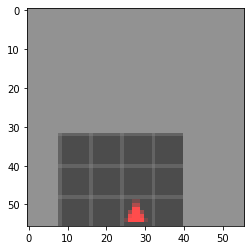

In [128]:
def make_env(color_shift=None, shift_strength=0.3):
    env = GridEnv(size=6) # gym.make('MiniGrid-Empty-Random-6x6-v0')
    env = RGBImgPartialObsWrapper(env) # Get pixel observations
    env = ImgObsWrapper(env) # Get rid of the 'mission' field
    if color_shift:
        env = ColorShiftWrapper(env, color_shift, shift_strength)
    env = SimplifyObsWrapper(env, False) # Downscale and grayscale
    return env
    
env = make_env()
obs = env.reset() # This now produces an RGB tensor only

print('Shape:', obs.shape, '=>', np.prod(obs.shape))
plt.imshow(obs.transpose(1, 2, 0))

In [129]:
class ValueNetwork(nn.Module):
    def __init__(self, obs_dim, n_acts, encoder, hidden_size=128):
        super().__init__()
        self.encoder = encoder

        test_input = torch.zeros(1, *obs_dim)
        with torch.no_grad():
            self.encoder_output_size = encoder(test_input).view(-1).shape[0]

        lta = LTA(hidden_size)
        self.value_layers = nn.Sequential(
            self.encoder,
            nn.Flatten(),
            nn.Linear(self.encoder_output_size, hidden_size),
            lta,
            nn.Linear(hidden_size * lta.n_tiles, n_acts))

        self._init_weights()

    def _init_weights(self):
        self.value_layers[-1].weight.data.fill_(0)
        self.value_layers[-1].bias.data.fill_(0)

    def forward(self, x):
        return self.value_layers(x)

In [130]:
device = 'cuda'

hidden_size = 64
encoder = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=5, stride=2),
        nn.ReLU(),
        nn.Conv2d(16, 32, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3),
        nn.ReLU())

# Create task agent
# model = rl.models.DDDQNNetwork(list(env.observation_space.shape), env.action_space.n,
#                 encoder=copy.deepcopy(encoder), hidden_size = hidden_size)
model = ValueNetwork(
        list(env.observation_space.shape), env.action_space.n,
        encoder=encoder, hidden_size=hidden_size).to(device)
agent = rl.agents.DDDQNAgent(env, model, log_freq=-1)

In [131]:
sum([p.numel() for p in model.parameters()])

107175

In [132]:
n_steps = 100000
print_freq = 1000

train_task_model(agent, env, n_steps, print_freq=print_freq)

Step: 1000 | Episodes: 7 | Ep rewards: 0.1393


e:\projects\continual_backprop\rl_representation\src\agents\dqn.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_data = [torch.tensor(e, dtype=torch.float32, device=self.device) \


Step: 2000 | Episodes: 12 | Ep rewards: 0.3672
Step: 3000 | Episodes: 14 | Ep rewards: 0.5272
Step: 4000 | Episodes: 13 | Ep rewards: 0.5346
Step: 5000 | Episodes: 9 | Ep rewards: 0.2618
Step: 6000 | Episodes: 14 | Ep rewards: 0.4924
Step: 7000 | Episodes: 17 | Ep rewards: 0.6250
Step: 8000 | Episodes: 15 | Ep rewards: 0.5321
Step: 9000 | Episodes: 23 | Ep rewards: 0.7337
Step: 10000 | Episodes: 26 | Ep rewards: 0.7651
Step: 11000 | Episodes: 37 | Ep rewards: 0.8157
Step: 12000 | Episodes: 56 | Ep rewards: 0.8856
Step: 13000 | Episodes: 47 | Ep rewards: 0.8734
Step: 14000 | Episodes: 57 | Ep rewards: 0.8852
Step: 15000 | Episodes: 55 | Ep rewards: 0.8870
Step: 16000 | Episodes: 55 | Ep rewards: 0.8855
Step: 17000 | Episodes: 62 | Ep rewards: 0.9032
Step: 18000 | Episodes: 82 | Ep rewards: 0.9207
Step: 19000 | Episodes: 78 | Ep rewards: 0.9207
Step: 20000 | Episodes: 85 | Ep rewards: 0.9268
Step: 21000 | Episodes: 90 | Ep rewards: 0.9295
Step: 22000 | Episodes: 93 | Ep rewards: 0.9345
S

# Testing the agent

In [33]:
def test_agent(agent, env, n_episodes=10):
    rewards = []
    for _ in range(n_episodes):
        obs = env.reset()
        done = False
        total_reward = 0.0
        global hist
        hist = []
        while not done:
            action = agent.sample_act(obs)
            obs, reward, done, _ = env.step(action)
            hist.append(obs)
            total_reward += reward
        rewards.append(total_reward)
    return np.mean(rewards)

In [34]:
base_reward = test_agent(agent, env, n_episodes=30)
print(f'Base agent reward: {base_reward:.2f}')

Base agent reward: 0.93


# Testing agent performance with color shifts

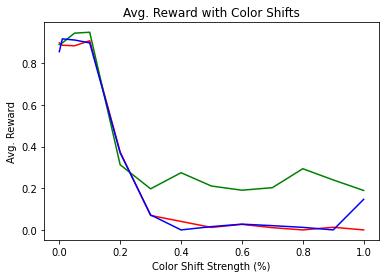

In [35]:
strengths = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
colors = {
    'r': (1, 0, 0),
    'g': (0, 1, 0),
    'b': (0, 0, 1)}

for color, rgb in colors.items():
    performance = []
    for strength in strengths:
        filter_env = make_env(color_shift=rgb, shift_strength=strength)
        filter_reward = test_agent(agent, filter_env, n_episodes=30)
        performance.append(filter_reward)

    # plot with red line color
    plt.plot(strengths, performance, color)

plt.title('Avg. Reward with Color Shifts')
plt.xlabel('Color Shift Strength (%)')
plt.ylabel('Avg. Reward');


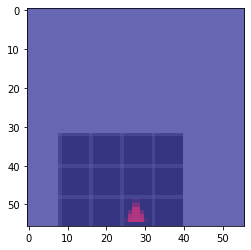

In [36]:
filter_env = make_env(color_shift=(0, 0, 1,), shift_strength=0.3)
plt.imshow(filter_env.reset())

## Remaining Tasks
- Create an activation function that zeros out certain nodes
- Get a mapping of the gradients for each nodes after many steps on the transfer task
- Make a function that makes a activation function mask for nodes within a certain percentile
- Try dropping those weights
- Try dropping nodes that meet a threshold number of outgoing weights dropped

In [37]:
# class NodeDropper()

In [39]:
def freeze_agent(agent):
    for param in agent.model.parameters():
        param.requires_grad = False
    for param in agent.target_model.parameters():
        param.requires_grad = False

def unfreeze_agent(agent):
    for param in agent.model.parameters():
        param.requires_grad = True
    for param in agent.target_model.parameters():
        param.requires_grad = True

In [99]:
filter_env = make_env(color_shift=(0, 0, 1,), shift_strength=0.2)
transfer_agent = rl.agents.DDDQNAgent(filter_env, copy.deepcopy(agent.model), log_freq=-1, learning_start=int(1e9))

In [100]:
steps = 10000
train_task_model(transfer_agent, filter_env, steps, print_freq=print_freq*5)

Step: 5000 | Episodes: 49 | Ep rewards: 0.2969


In [101]:
# Get gradient errors on the transfer problem
transfer_agent.optimizer.zero_grad()
grad_steps = 50
grad_sums = [torch.zeros_like(p) for p in transfer_agent.model.parameters()]
for _ in range(grad_steps):
    transfer_agent.calculate_losses().mean().backward()
    for i, param in enumerate(transfer_agent.model.parameters()):
        grad_sums[i] += torch.abs(param.grad)
        # print(torch.sum(param.grad != 0) / param.numel())
        # break
    transfer_agent.optimizer.zero_grad()

In [102]:
param = list(transfer_agent.model.parameters())[0]
torch.sum(param == 0) / param.numel()

tensor(0., device='cuda:0')

In [103]:
torch.sum(grad_sums[0] != 0) / grad_sums[0].numel()

tensor(0.0430, device='cuda:0')

In [119]:
reset_frac = 0.3
for i, (grads, param) in enumerate(zip(grad_sums, transfer_agent.model.parameters())):
    reset_threshold = torch.quantile(grads, 1-reset_frac)
    reset_threshold = max(reset_threshold, 1e-5)
    mask = grads < reset_threshold
    print('Param #{}, {:.2f}% removed'.format(i, 100 - (mask.sum().item() / mask.numel() * 100)))
    with torch.no_grad():
        param *= mask.float()

Param #0, 4.30% removed
Param #1, 4.30% removed
Param #2, 2.08% removed
Param #3, 54.69% removed
Param #4, 47.43% removed
Param #5, 85.71% removed


In [120]:
base_reward = test_agent(transfer_agent, filter_env, n_episodes=30)
print(f'Transfer agent reward: {base_reward:.2f}')

Transfer agent reward: 0.03


In [76]:
transfer_agent.model

<generator object Module.parameters at 0x0000027A24632EB0>

In [69]:
transfer_agent.model.value_layers[:-1]

Sequential(
  (0): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=9408, out_features=256, bias=True)
    (2): ReLU()
  )
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
)

In [ ]:
transfer_agent.model.value_layers[:-1](torch.tensor([obs], device='cuda').float())

tensor([[0.1843, 0.0000, 0.0000, 0.1811, 0.0530, 0.0000, 0.0000, 0.2444, 0.0000,
         0.2402, 0.0000, 0.1215, 0.2800, 0.0000, 0.1117, 0.1126, 0.0000, 0.1164,
         0.1206, 0.0000, 0.0000, 0.0798, 0.0000, 0.0000, 0.2593, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0151, 0.0000, 0.1790, 0.0000, 0.1138, 0.0107, 0.0000,
         0.1679, 0.1016, 0.0000, 0.0000, 0.2751, 0.1968, 0.0000, 0.0000, 0.1790,
         0.0055, 0.1117, 0.1180, 0.1462, 0.0000, 0.0000, 0.0000, 0.0233, 0.2732,
         0.0160, 0.0236, 0.0000, 0.0000, 0.0228, 0.1675, 0.3149, 0.0000, 0.1594,
         0.0000, 0.1841, 0.0000, 0.1351, 0.1047, 0.1016, 0.1207, 0.0240, 0.1527,
         0.0178, 0.0000, 0.0000, 0.1431, 0.3437, 0.2592, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0529, 0.0000, 0.0051, 0.0000, 0.0000, 0.0000, 0.3146, 0.1377,
         0.0000, 0.1762, 0.0000, 0.3480, 0.0000, 0.0000, 0.0000, 0.2113, 0.0022,
         0.0000, 0.0000, 0.1245, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.1392, 0.0000, 0.2

In [63]:
transfer_agent.calculate_losses()

e:\projects\continual_backprop\rl_representation\src\agents\dqn.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_data = [torch.tensor(e, dtype=torch.float32, device=self.device) \


tensor([6.5002e-03, 6.5002e-03, 1.7247e-03, 1.0616e-03, 8.9955e-03, 6.2190e-03,
        4.4834e-03, 6.2189e-03, 2.8174e-02, 6.5002e-03, 6.2657e-03, 6.0987e-03,
        6.5002e-03, 1.1178e-02, 6.2190e-03, 6.5002e-03, 1.0072e-02, 7.3109e-03,
        6.2522e-03, 6.5002e-03, 4.3774e-02, 6.5002e-03, 6.5002e-03, 6.5002e-03,
        6.5002e-03, 3.3885e-01, 6.5002e-03, 6.5002e-03, 6.5002e-03, 3.4057e-03,
        6.5002e-03, 6.5002e-03, 1.3708e-03, 6.0987e-03, 1.0370e-02, 6.5002e-03,
        6.5002e-03, 8.0011e-04, 1.0692e-02, 6.5002e-03, 7.3109e-03, 2.1784e-04,
        3.0771e-02, 5.0356e-01, 6.5002e-03, 8.9077e-03, 6.5002e-03, 6.5002e-03,
        4.2381e-03, 4.6205e-02, 6.5002e-03, 3.4494e-03, 6.5002e-03, 6.5002e-03,
        6.6841e-02, 2.8750e-02, 6.5002e-03, 1.0072e-02, 4.4834e-03, 2.1395e-02,
        6.5002e-03, 6.2096e-03, 8.9955e-03, 6.2190e-03, 6.2190e-03, 5.0356e-01,
        3.4057e-03, 6.5002e-03, 6.2522e-03, 6.2190e-03, 6.2189e-03, 6.0987e-03,
        6.5002e-03, 8.9077e-03, 6.2190e-

In [55]:
a = list(transfer_agent.model.parameters())[2].grad
a.shape

torch.Size([128, 256])

In [74]:
print(list(transfer_agent.model.parameters())[-2].grad)
print(next(transfer_agent.model.parameters()).grad)
print(next(transfer_agent.model.parameters()).grad.sum())

tensor([[-2.7559e-03, -4.7504e-03, -1.2179e-04, -3.0968e-03, -2.8429e-04,
         -1.7875e-04, -1.6766e-03, -1.4572e-03, -7.1463e-04, -1.5418e-03,
          0.0000e+00, -5.3354e-03,  5.3874e-04, -2.5993e-04, -1.0417e-03,
         -8.3746e-04,  0.0000e+00, -6.4540e-03, -3.2519e-04,  0.0000e+00,
          0.0000e+00, -5.8134e-04,  0.0000e+00, -3.6056e-03, -7.7094e-04,
          0.0000e+00,  0.0000e+00,  0.0000e+00, -1.6574e-03, -4.0612e-04,
          0.0000e+00, -9.3265e-03,  0.0000e+00, -2.7177e-03, -3.3994e-04,
         -1.7064e-04, -9.2044e-03, -9.3307e-04,  0.0000e+00,  0.0000e+00,
          5.4531e-04, -1.1952e-03,  0.0000e+00,  0.0000e+00, -1.4431e-03,
         -6.4529e-03, -9.0573e-04, -1.2076e-03, -1.0193e-02,  0.0000e+00,
          0.0000e+00,  0.0000e+00, -5.5482e-04,  5.2320e-04, -5.4833e-04,
          2.1238e-05, -7.7945e-05,  0.0000e+00, -4.6862e-04, -1.0566e-02,
          6.0719e-04,  0.0000e+00, -7.7247e-03, -1.1482e-03, -5.6607e-03,
         -1.9900e-04, -4.1855e-03, -7.

In [31]:
sum((next(transfer_agent.model.parameters()).grad != 0).view(-1))

KeyboardInterrupt: 

In [ ]:
transfer_agent.calculate_losses

In [32]:
transfer_agent.model.value_layers[0][1].weight.requires_grad

False

In [35]:
agent.model.value_layers[0][1].weight.requires_grad

True